In [1]:
import librosa
import librosa.display
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pylab
from scipy import signal
from tqdm.notebook import tqdm
from glob import glob
import gc

import tensorflow as tf
import keras
from keras import layers, losses
from keras.models import Model, load_model
import keras.backend as K
from keras.activations import leaky_relu
from keras.losses import binary_crossentropy, mean_squared_error

from keras.layers import Input,Conv2D, Layer, UpSampling2D, MaxPooling2D, Dense, Flatten, Lambda, GlobalAveragePooling2D, Conv2DTranspose, Reshape, BatchNormalization, Dropout, ELU, ReLU
from tensorflow.keras.utils import plot_model

import os
import pdb

C:\Users\GP65\anaconda3\envs\py39\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


## Getting the DataSet

In [17]:
train_paths = glob('D:/Projects/Orpheus_ai/DataSet/Spectrograms/HalfMEL_dbscale/*')[:-100]
test_paths = glob('D:/Projects/Orpheus_ai/DataSet/Spectrograms/HalfMEL_dbscale/*')[-100:]

BATCH_SIZE = 4
AUTOTUNE = tf.data.experimental.AUTOTUNE
min_level_db = -80 

In [18]:
# for x in tqdm(train_paths):
#     if np.load(x).shape != (128,216):
#         print(x)
#         os.remove(x)
        

In [19]:
def data_loader(path):
    path = bytes.decode(path.numpy())
    spec = tf.cast(np.load(path),tf.float32)
    spec = tf.expand_dims(spec,axis=-1)
    return spec

def normalize(S):
    return np.clip((((S - min_level_db) / -min_level_db)*2.)-1., -1, 1)

def denormalize(S):
    return (((np.clip(S, -1, 1)+1.)/2.) * -min_level_db) + min_level_db


In [21]:
def get_dataset(data_paths):
    dataset = tf.data.Dataset.from_tensor_slices(data_paths)
    dataset = dataset.map(lambda x : tf.py_function(data_loader, [x], [tf.float32]), num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(lambda x : tf.py_function(normalize, [x], [tf.float32]), num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.repeat()
    return dataset

In [72]:
X_train = get_dataset(train_paths)
X_test = np.array([np.expand_dims(normalize(np.load(i)),axis=-1) for i in test_paths])

In [23]:
# # ## Direct
# dataframe = pd.read_pickle('D:/Projects/Orpheus_ai/DataSet/inst_spectrogram.pkl')
# X = dataframe['stft_logscale']
# var = np.var(np.concatenate(X.apply(lambda a: np.expand_dims(a,0)).values,axis=0))
# del(X)
# del(dataframe)
# gc.collect()
# # X_train = X.sample(n=100).sort_index()
# # X_test = X[~X.index.isin(X_train.index)]
# # X_train, X_test = np.concatenate(X_train.apply(lambda a: np.expand_dims(a,0)).values,axis=0), np.concatenate(X_test.apply(lambda a: np.expand_dims(a,0)).values,axis=0)

# # X_train, X_test = tf.expand_dims(X_train,axis=-1), tf.expand_dims(X_train,axis=-1)

## Model Architecture

In [108]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.beta = (
            beta  # This parameter is best kept between [0.25, 2] as per the paper.
        )

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = self.beta * tf.reduce_mean(
            (tf.stop_gradient(quantized) - x) ** 2
        )
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices
    
    def get_config(self):

        config = super().get_config().copy()
        return config
    
class VQVAETrainer(keras.models.Model):
    
    def __init__(self, latent_dim=32, num_embeddings=128, train_variance=1, **kwargs):
        super(VQVAETrainer, self).__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae,self.encoder,self.quantizer, self.decoder = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")
        
    def call(self, inputs, training=False):
        ## Dummy call to just save this
        x = inputs
        x = self.vqvae(x)
        return x

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2)
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }
    
    
def get_encoder(latent_dim=16):
    
    encoder_inputs = keras.Input(shape=(128, 216, 1))
    
    x = layers.Conv2D(32, 3, strides=1, padding="same")(encoder_inputs) 
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2D(64, 3, strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2D(256, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2D(512, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    
    encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")


def get_decoder(latent_dim=16):
    latent_inputs = keras.Input(shape=get_encoder(latent_dim).output.shape[1:])
    
    x = layers.Conv2DTranspose(512, 3, strides=2, padding="same")(latent_inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2DTranspose(256, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2DTranspose(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2DTranspose(64, 3, strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2DTranspose(32, 3, strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    decoder_outputs = layers.Conv2DTranspose(1, 3, padding="same")(x)
    decoder_outputs = layers.Resizing(128, 216)(decoder_outputs)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")

    
def get_vqvae(latent_dim=16, num_embeddings=64):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = keras.Input(shape=(128, 216, 1))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    
    vqvae = keras.Model(inputs, reconstructions, name="vq_vae")
    encoder = keras.Model(inputs, encoder_outputs, name="vq_enc")
    quantizer = keras.Model(inputs, quantized_latents, name="vq_quantizer")
    return vqvae,encoder,quantizer,decoder

In [109]:
# train_var = np.var(np.array([normalize(np.load(i)) for i in train_paths[:10000]]))

In [113]:
vqvae= VQVAETrainer(latent_dim=8, num_embeddings=2048, train_variance=1)
vqvae._set_inputs(tf.ones((1, 128, 216, 1)))
vqvae.build((None, 128, 216, 1))

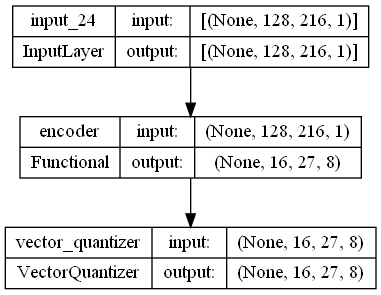

In [114]:
plot_model(vqvae.quantizer,show_shapes=True)

In [117]:
model_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='reconstruction_loss', patience=3,restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath='D:/Projects/Orpheus_ai/DataSet/model_save_logs/VQVAE/model.{epoch:02d}-{loss:.5f}',monitor='reconstruction_loss',save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir='D:/Projects/Orpheus_ai/DataSet/model_save_logs/VQVAE/tfboard_logs'),
]

In [118]:
vqvae.compile(optimizer='adam')
history = vqvae.fit(X_train, epochs=20, callbacks=model_callbacks,steps_per_epoch=250)
          #steps_per_epoch=np.ceil(len(train_paths)/BATCH_SIZE),)

Epoch 1/20
250/250 [==============================] - ETA: 0s - loss: 2.3175 - reconstruction_loss: 0.0869 - vqvae_loss: 2.2095

INFO:tensorflow:Assets written to: D:/Projects/Orpheus_ai/DataSet/model_save_logs/VQVAE\model.01-1.56433\assets


INFO:tensorflow:Assets written to: D:/Projects/Orpheus_ai/DataSet/model_save_logs/VQVAE\model.01-1.56433\assets


250/250 [==============================] - 29s 108ms/step - loss: 2.3145 - reconstruction_loss: 0.0869 - vqvae_loss: 2.2066
Epoch 2/20
250/250 [==============================] - ETA: 0s - loss: 0.3393 - reconstruction_loss: 0.0611 - vqvae_loss: 0.2773

INFO:tensorflow:Assets written to: D:/Projects/Orpheus_ai/DataSet/model_save_logs/VQVAE\model.02-0.27381\assets


INFO:tensorflow:Assets written to: D:/Projects/Orpheus_ai/DataSet/model_save_logs/VQVAE\model.02-0.27381\assets


250/250 [==============================] - 27s 108ms/step - loss: 0.3390 - reconstruction_loss: 0.0611 - vqvae_loss: 0.2770
Epoch 3/20
250/250 [==============================] - ETA: 0s - loss: 0.0467 - reconstruction_loss: 0.0330 - vqvae_loss: 0.0124

INFO:tensorflow:Assets written to: D:/Projects/Orpheus_ai/DataSet/model_save_logs/VQVAE\model.03-0.03597\assets


INFO:tensorflow:Assets written to: D:/Projects/Orpheus_ai/DataSet/model_save_logs/VQVAE\model.03-0.03597\assets


250/250 [==============================] - 27s 109ms/step - loss: 0.0466 - reconstruction_loss: 0.0330 - vqvae_loss: 0.0124
Epoch 4/20
250/250 [==============================] - ETA: 0s - loss: 0.0360 - reconstruction_loss: 0.0271 - vqvae_loss: 0.0073

INFO:tensorflow:Assets written to: D:/Projects/Orpheus_ai/DataSet/model_save_logs/VQVAE\model.04-0.03383\assets


INFO:tensorflow:Assets written to: D:/Projects/Orpheus_ai/DataSet/model_save_logs/VQVAE\model.04-0.03383\assets


250/250 [==============================] - 27s 109ms/step - loss: 0.0359 - reconstruction_loss: 0.0271 - vqvae_loss: 0.0073
Epoch 5/20
250/250 [==============================] - ETA: 0s - loss: 0.0360 - reconstruction_loss: 0.0227 - vqvae_loss: 0.0116

INFO:tensorflow:Assets written to: D:/Projects/Orpheus_ai/DataSet/model_save_logs/VQVAE\model.05-0.03023\assets


INFO:tensorflow:Assets written to: D:/Projects/Orpheus_ai/DataSet/model_save_logs/VQVAE\model.05-0.03023\assets


250/250 [==============================] - 28s 109ms/step - loss: 0.0360 - reconstruction_loss: 0.0227 - vqvae_loss: 0.0116
Epoch 6/20
250/250 [==============================] - ETA: 0s - loss: 0.0251 - reconstruction_loss: 0.0208 - vqvae_loss: 0.0051

INFO:tensorflow:Assets written to: D:/Projects/Orpheus_ai/DataSet/model_save_logs/VQVAE\model.06-0.02606\assets


INFO:tensorflow:Assets written to: D:/Projects/Orpheus_ai/DataSet/model_save_logs/VQVAE\model.06-0.02606\assets


250/250 [==============================] - 28s 110ms/step - loss: 0.0251 - reconstruction_loss: 0.0208 - vqvae_loss: 0.0051
Epoch 7/20
250/250 [==============================] - ETA: 0s - loss: 0.0227 - reconstruction_loss: 0.0183 - vqvae_loss: 0.0044

INFO:tensorflow:Assets written to: D:/Projects/Orpheus_ai/DataSet/model_save_logs/VQVAE\model.07-0.02339\assets


INFO:tensorflow:Assets written to: D:/Projects/Orpheus_ai/DataSet/model_save_logs/VQVAE\model.07-0.02339\assets


250/250 [==============================] - 28s 110ms/step - loss: 0.0227 - reconstruction_loss: 0.0183 - vqvae_loss: 0.0044
Epoch 8/20
250/250 [==============================] - 20s 80ms/step - loss: 0.0270 - reconstruction_loss: 0.0189 - vqvae_loss: 0.0066
Epoch 9/20
250/250 [==============================] - 21s 84ms/step - loss: 0.0253 - reconstruction_loss: 0.0210 - vqvae_loss: 0.0057
Epoch 10/20
250/250 [==============================] - 20s 79ms/step - loss: 0.0295 - reconstruction_loss: 0.0199 - vqvae_loss: 0.0079


In [132]:
pred = vqvae.predict(X_test)
print("MSE: ",np.mean((X_test-pred)**2))

4/4 [==============================] - 2s 437ms/step
MSE:  0.0050505293


In [120]:
# import plotly.express as px
# px.line(pd.DataFrame(history.history))

### Rough Test

In [133]:
# vqvae = keras.models.load_model('D:/Projects/Orpheus_ai/DataSet/model_save_logs/Saved Models/VQVAE(7K)_normalized80lowrez_5e-03recloss')

In [134]:
import librosa
import librosa.display
import IPython.display as ipd

sr = 22050
hop_length = 1024
n_fft = hop_length*4

song_info = pd.read_csv('D:/Projects/Orpheus_ai/DataSet/main_dataframe.csv')

In [135]:
test_dataset = X_test
model_output = vqvae.predict(test_dataset)

4/4 [==============================] - 1s 437ms/step


In [161]:
test_paths[65]

'D:/Projects/Orpheus_ai/DataSet/Spectrograms/HalfMEL_dbscale\\154896.npy'

In [162]:
index = 56

## Original
S = test_dataset[index,:,:,0]
S = denormalize(S)

## Original
S_hat = model_output[index,:,:,0]
S_hat = denormalize(S_hat)

In [163]:
def denormalize(S):
    return (((np.clip(S, -1, 1)+1.)/2.) * -min_level_db) + min_level_db


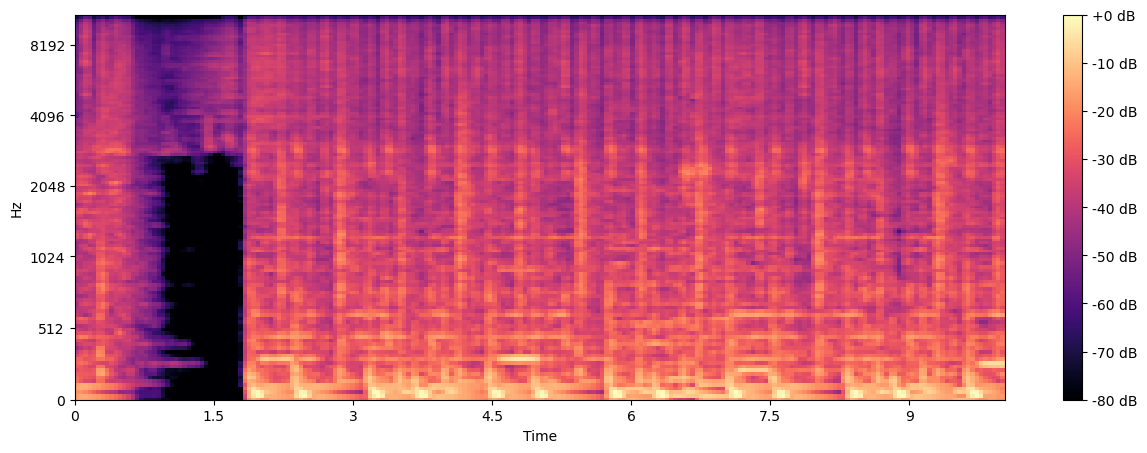

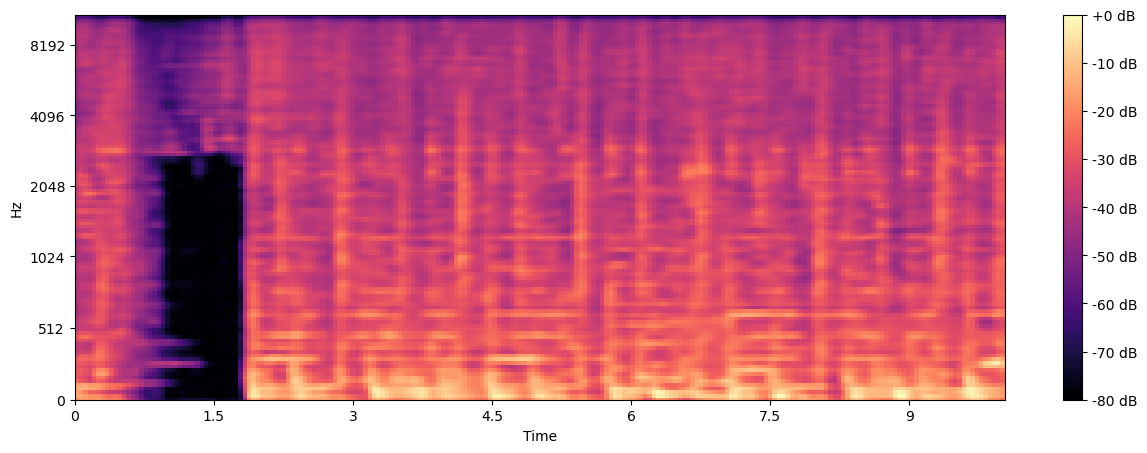

In [164]:
## Original
plt.figure(figsize=(15, 5))
librosa.display.specshow(S, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel',cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.show()

## Recreated
plt.figure(figsize=(15, 5))
librosa.display.specshow(S_hat, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel',cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.show()

In [165]:
output = librosa.feature.inverse.mel_to_audio(librosa.db_to_power(S),sr=sr,n_fft=n_fft,hop_length=hop_length)
ipd.Audio(output, rate=sr)

In [166]:
output_hat = librosa.feature.inverse.mel_to_audio(librosa.db_to_power(S_hat),sr=sr,n_fft=n_fft,hop_length=hop_length)
ipd.Audio(output_hat, rate=sr)

In [160]:
np.mean((output_hat-output)**2)

3.3978155e-05

In [102]:
# vqvae.save('D:/Projects/Orpheus_ai/DataSet/model_save_logs/Saved Models/VQVAE(7K)_normalized80lowrez_5e-03recloss')